In [2]:
import math
math.sqrt(8.6**2 + 1.3**2)

8.697700845625814

In [1]:
import samtools as sam
# working_dir = 'C:/Users/Samuel_DeLap.UMLADCO/Documents/DeLap/AxoChewing'
# working_dir = 'C:/Users/sjcde/OneDrive/Documents/AxoChewing/'
working_dir = 'C:/Users/sjcde/Documents/AxoChewing/'

Loading DLC 2.2.2...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [2]:
import os
project = sam.load_project(working_dir=working_dir)
training_data_path = os.path.join(project['working_dir'], "trainingdata")
trial = os.listdir(training_data_path)[0]

trial

c:\Users\sjcde\Documents\deadROMM-tools\samtools.py:89: SyntaxWarning: Default project name in use
  warnings.warn('Default project name in use', SyntaxWarning)


'22JUL2021_Axo18_t04_c_strikeNchews'

In [2]:
sam.autocorrect(working_dir, threshold=5)

1600.0
done! saving...


In [97]:
# Vars and imports
import cv2
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
new_data_path = working_dir +'/trials'
trial = '22JUL2021_Axo18_t04_c_strikeNchews'
iteration = 0
search_area = 10
cam = 'cam1'
hdf = pd.read_hdf(new_data_path + '/' + trial + '/' + 'it' + str(iteration) + '/' + trial + '-Predicted2DPoints.h5')
threshold = 4

In [99]:
import cv2
import numpy as np



True

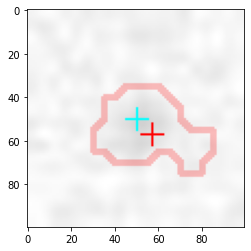

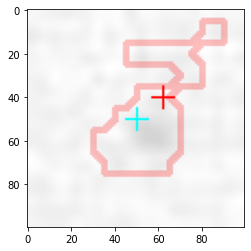

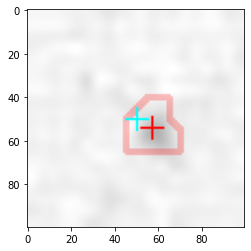

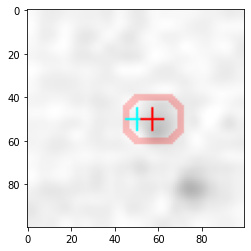

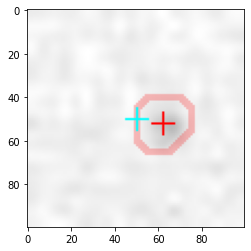

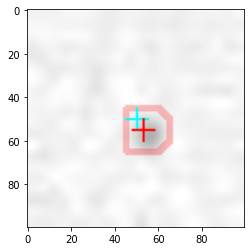

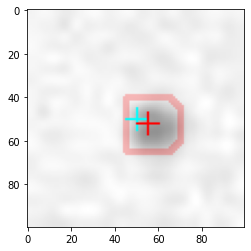

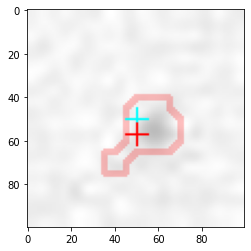

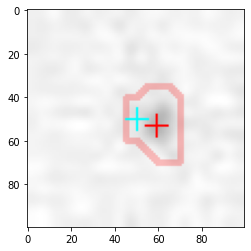

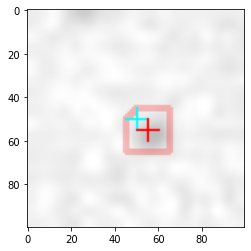

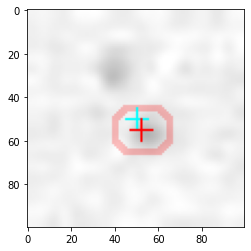

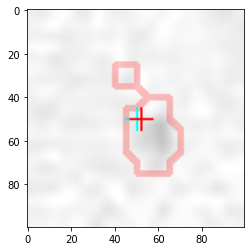

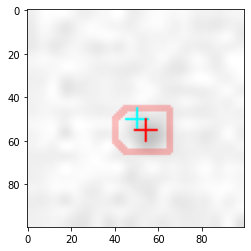

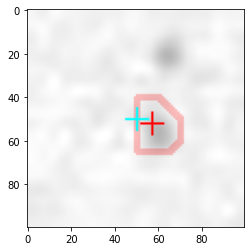

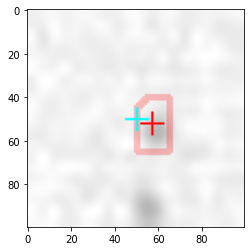

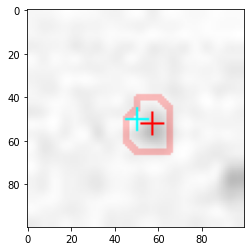

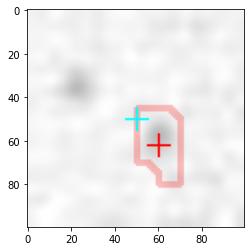

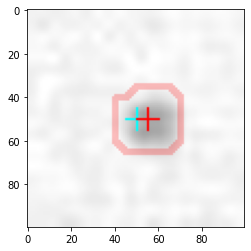

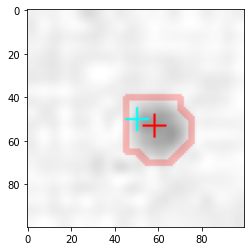

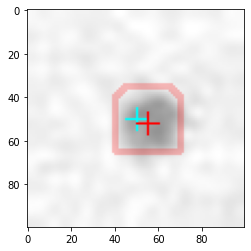

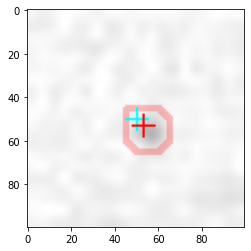

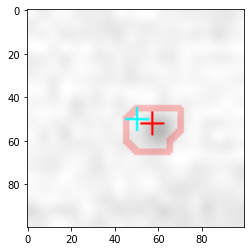

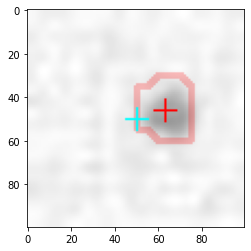

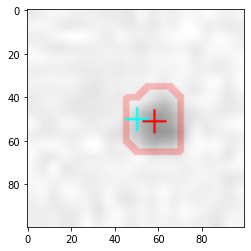

In [100]:
%matplotlib inline
# Image processing
frame = cv2.imread('sample_frame.jpg', -1)
rgb_planes = cv2.split(frame)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_norm_planes.append(norm_img)

result_norm = cv2.merge(result_norm_planes)

# For each marker in the frame
parts_unique = samtools.getBodypartsFromXmaExport(working_dir)
# parts_unique = [parts_unique[0]]
for part in parts_unique:
    # Find point and offsets
    x_float = hdf.loc[0, part + '_' + cam + '_X']
    y_float = hdf.loc[0, part + '_' + cam + '_Y']
    x_start = int(x_float-search_area+0.5)
    y_start = int(y_float-search_area+0.5)
    x_end = int(x_float+search_area+0.5)
    y_end = int(y_float+search_area+0.5)

    # Crop image to marker vicinity
    subimage = result_norm[y_start:y_end, x_start:x_end]

    # Convert To float
    subimage_float = subimage.astype(np.float32)
    
    # Threshold

    # # Create Blurred image
    # radius = 6 # Must be 6 or higher
    # sigma = radius * math.sqrt(2 * math.log(255)) - 1
    # subimage_blurred = cv2.GaussianBlur(subimage_float, (2 * radius + 1, radius + 1), sigma)

    # # Subtract Background
    # subimage_diff = subimage_float-subimage_blurred
    # subimage_diff = cv2.normalize(subimage_diff, None, 0,255,cv2.NORM_MINMAX).astype(np.uint8)

    # # Median
    # subimage_median = cv2.medianBlur(subimage_diff, 3)

    # Threshold
    subimage_gray = cv2.cvtColor(subimage, cv2.COLOR_BGR2GRAY)
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(subimage_gray)
    thres = 0.5 * minVal + 0.5 * np.mean(subimage_gray) + threshold * 0.01 * 255
    ret, subimage_threshold =  cv2.threshold(subimage_gray, thres, 255, cv2.THRESH_BINARY_INV)

    # # LUT
    # subimage_median_filtered = samtools.filter_image(subimage_median, krad=2)

    # # Thresholding
    # subimage_median_filtered = cv2.cvtColor(subimage_median_filtered, cv2.COLOR_BGR2GRAY)
    # minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(subimage_median_filtered)
    # thres = 0.5 * minVal + 0.5 * np.mean(subimage_median_filtered) + threshold * 0.01 * 255
    # ret, subimage_threshold =  cv2.threshold(subimage_median_filtered, thres, 255, cv2.THRESH_BINARY_INV)

    # Gaussian blur
    subimage_gaussthresh = cv2.GaussianBlur(subimage_threshold, (3,3), 1.3)

    # Find contours
    contours, _ = cv2.findContours(subimage_gaussthresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE, offset=(x_start,y_start))
    contours_im = [contour-[x_start, y_start] for contour in contours]

    # Find closest contour
    dist = 1000
    best_index = -1
    detected_centers = {}
    for i in range(len(contours)):
        detected_center, circle_radius = cv2.minEnclosingCircle(contours[i])
        distTmp = math.sqrt((x_float - detected_center[0])**2 + (y_float - detected_center[1])**2)
        detected_centers[round(distTmp, 4)] = detected_center
        if distTmp < dist:
            best_index = i
            dist = distTmp
    if best_index >= 0:
        detected_center, _ = cv2.minEnclosingCircle(contours[best_index])
        detected_center_im, _ = cv2.minEnclosingCircle(contours_im[best_index])
        samtools.show_crop(subimage, center=search_area, contours = [contours_im[best_index]], detected_marker = detected_center_im)
        # samtools.show_crop(subimage_median, center=search_area, contours = [contours_im[best_index]], detected_marker = detected_center_im)
        # samtools.show_crop(subimage_median_filtered, center=search_area, contours = [contours_im[best_index]], detected_marker = detected_center_im)
        # samtools.show_c rop(subimage_threshold, center=search_area, contours=contours_im,detected_marker = detected_center_im)
        # samtools.show_crop(subimage_gaussthresh, center=search_area, contours = [contours_im[best_index]], detected_marker = detected_center_im)
    else:
        print('Unable to find a good contour here!')
        